Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, davies_bouldin_score

Loading the Dataset

In [2]:
df1 = pd.read_excel("Sample - Superstore.xls")
print(df1.head())

   Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  US-2019-103800 2019-01-03 2019-01-07  Standard Class    DP-13000   
1       2  US-2019-112326 2019-01-04 2019-01-08  Standard Class    PO-19195   
2       3  US-2019-112326 2019-01-04 2019-01-08  Standard Class    PO-19195   
3       4  US-2019-112326 2019-01-04 2019-01-08  Standard Class    PO-19195   
4       5  US-2019-141817 2019-01-05 2019-01-12  Standard Class    MB-18085   

   Customer Name      Segment Country/Region          City  ... Postal Code  \
0  Darren Powers     Consumer  United States       Houston  ...       77095   
1  Phillina Ober  Home Office  United States    Naperville  ...       60540   
2  Phillina Ober  Home Office  United States    Naperville  ...       60540   
3  Phillina Ober  Home Office  United States    Naperville  ...       60540   
4     Mick Brown     Consumer  United States  Philadelphia  ...       19143   

    Region       Product ID         Category Sub-C

In [3]:
missing_values = df1.isnull().sum()
print(missing_values)

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country/Region    0
City              0
State/Province    0
Postal Code       0
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
Quantity          0
Discount          0
Profit            0
dtype: int64


In [4]:
columns_to_drop = ['Customer Name', 'Product Name','Row ID', 'Ship Date', 'Ship Mode', 'Segment' , 'Country/Region', 'City', 'State/Province', 'Postal Code', 'Region','Product ID', 'Discount', 'Quantity', 'Category', 'Sub-Category', 'Profit']
df2 = df1.drop(columns_to_drop, axis=1)
print(df2)

             Order ID Order Date Customer ID    Sales
0      US-2019-103800 2019-01-03    DP-13000   16.448
1      US-2019-112326 2019-01-04    PO-19195    3.540
2      US-2019-112326 2019-01-04    PO-19195   11.784
3      US-2019-112326 2019-01-04    PO-19195  272.736
4      US-2019-141817 2019-01-05    MB-18085   19.536
...               ...        ...         ...      ...
10189  US-2022-143259 2022-12-30    PO-18865   52.776
10190  US-2022-115427 2022-12-30    EB-13975   20.720
10191  US-2022-156720 2022-12-30    JM-15580    3.024
10192  US-2022-143259 2022-12-30    PO-18865   90.930
10193  CA-2022-143500 2022-12-30    HO-15230    3.024

[10194 rows x 4 columns]


In [5]:
df2['Order Date'] = pd.to_datetime(df2['Order Date'])

df3 = df2.groupby('Customer ID').agg(
    Last_Purchase_Date=('Order Date', 'max'),
    Total_Orders=('Order ID', 'nunique'),
    Total_Sales=('Sales', 'sum')
).reset_index()

print(df3)

    Customer ID Last_Purchase_Date  Total_Orders  Total_Sales
0      AA-10315         2022-06-29             5     5563.560
1      AA-10375         2022-12-11             9     1056.390
2      AA-10480         2022-04-15             4     1790.512
3      AA-10645         2022-11-05             6     5086.935
4      AB-10015         2021-11-10             3      886.156
..          ...                ...           ...          ...
799    XP-21865         2022-11-17            13     2503.156
800    YC-21895         2022-12-26             5     5454.350
801    YS-21880         2022-12-21             8     6720.444
802    ZC-21910         2022-11-06            13     8025.707
803    ZD-21925         2022-06-11             5     1493.944

[804 rows x 4 columns]


In [6]:
max_date = df3['Last_Purchase_Date'].max()
df3['Last_Purchase_Date'] = (max_date - df3['Last_Purchase_Date']).dt.days + 1

print(df3)

    Customer ID  Last_Purchase_Date  Total_Orders  Total_Sales
0      AA-10315                 185             5     5563.560
1      AA-10375                  20             9     1056.390
2      AA-10480                 260             4     1790.512
3      AA-10645                  56             6     5086.935
4      AB-10015                 416             3      886.156
..          ...                 ...           ...          ...
799    XP-21865                  44            13     2503.156
800    YC-21895                   5             5     5454.350
801    YS-21880                  10             8     6720.444
802    ZC-21910                  55            13     8025.707
803    ZD-21925                 203             5     1493.944

[804 rows x 4 columns]


In [7]:
df3.rename(columns={'Last_Purchase_Date': 'R', 'Total_Sales': 'M', 'Total_Orders': 'F'}, inplace=True)

print(df3)

    Customer ID    R   F         M
0      AA-10315  185   5  5563.560
1      AA-10375   20   9  1056.390
2      AA-10480  260   4  1790.512
3      AA-10645   56   6  5086.935
4      AB-10015  416   3   886.156
..          ...  ...  ..       ...
799    XP-21865   44  13  2503.156
800    YC-21895    5   5  5454.350
801    YS-21880   10   8  6720.444
802    ZC-21910   55  13  8025.707
803    ZD-21925  203   5  1493.944

[804 rows x 4 columns]


In [8]:
scaler = MinMaxScaler()
df3[['R', 'F', 'M']] = scaler.fit_transform(df3[['R', 'F', 'M']])
print(df3)

    Customer ID         R       F         M
0      AA-10315  0.157940  0.2500  0.222010
1      AA-10375  0.016309  0.5000  0.041998
2      AA-10480  0.222318  0.1875  0.071318
3      AA-10645  0.047210  0.3125  0.202974
4      AB-10015  0.356223  0.1250  0.035199
..          ...       ...     ...       ...
799    XP-21865  0.036910  0.7500  0.099780
800    YC-21895  0.003433  0.2500  0.217648
801    YS-21880  0.007725  0.4375  0.268214
802    ZC-21910  0.046352  0.7500  0.320345
803    ZD-21925  0.173391  0.2500  0.059474

[804 rows x 4 columns]


In [9]:
for col in ['R', 'F', 'M']:
    top_values = df3[col].nlargest(5)
    print(f"Top 5 {col} values:\n{top_values}\n")

Top 5 R values:
562    1.000000
310    0.974249
648    0.941631
164    0.887554
796    0.857511
Name: R, dtype: float64

Top 5 F values:
276    1.0000
100    0.8125
262    0.8125
713    0.8125
82     0.7500
Name: F, dtype: float64

Top 5 M values:
711    1.000000
752    0.760732
632    0.603578
741    0.582741
6      0.577866
Name: M, dtype: float64



In [10]:
for X in ['R', 'F', 'M']:
    mean = df3[X].mean()
    print(f"{X} mean:\n{mean}\n")

R mean:
0.12533576751435951

F mean:
0.33527674129353235

M mean:
0.11537828135472929



Clustering Using Elbow and Kmeans

C:\Users\USER\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\USER\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\USER\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\USER\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(

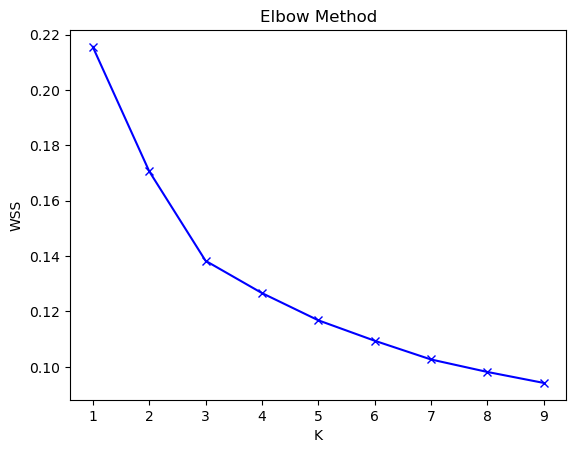

In [11]:
X = df3[['R', 'F', 'M']]

distortions = []
K = range(1, 10)
for k in K:
    kmeans_model = KMeans(n_clusters=k, n_init=5).fit(X)
    kmeans_model.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeans_model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('WSS')
plt.title('Elbow Method')
plt.show()

In [12]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [13]:
df3['Cluster'] = kmeans.labels_

cluster_summary = df3.groupby('Cluster')[['R', 'F', 'M']].mean().round(2)
print(cluster_summary)

            R     F     M
Cluster                  
0        0.44  0.17  0.07
1        0.07  0.50  0.18
2        0.07  0.25  0.08


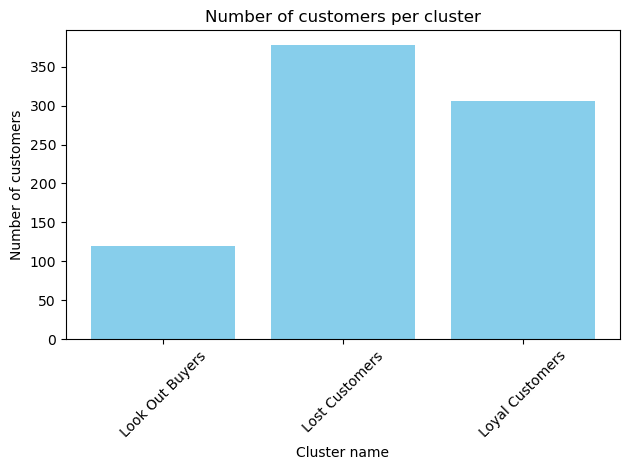

In [14]:
labels = kmeans.labels_

labels_map = {
    0: 'Look Out Buyers',
    1: 'Loyal Customers',
    2: 'Lost Customers'
}

label_names = [labels_map[label] for label in labels]

unique, counts = np.unique(label_names, return_counts=True)
cluster_counts = dict(zip(unique, counts))

plt.bar(cluster_counts.keys(), cluster_counts.values(), color='skyblue')
plt.xlabel('Cluster name')
plt.ylabel('Number of customers')
plt.title('Number of customers per cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Clustering Using Silhouette and Kmeans

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

Best k based on Silhouette Score: 2


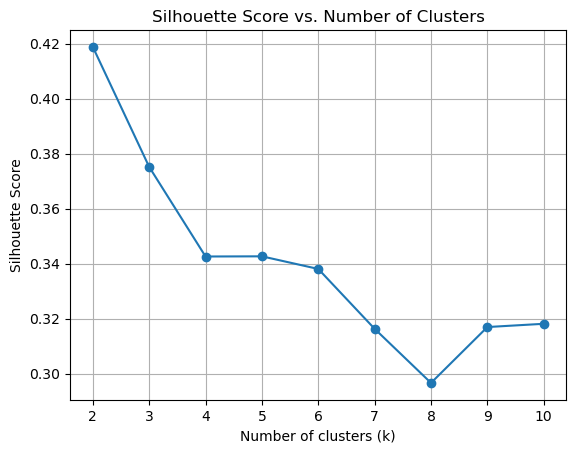

In [15]:
X = df3[['R', 'F', 'M']]  

silhouette_scores = []
k_range = range(2, 11)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Best k based on Silhouette Score: {best_k}")

plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [16]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

In [17]:
df3['Cluster'] = kmeans.labels_

cluster_summary = df3.groupby('Cluster')[['R', 'F', 'M']].mean().round(2)
print(cluster_summary)

            R     F     M
Cluster                  
0        0.36  0.17  0.06
1        0.06  0.38  0.13


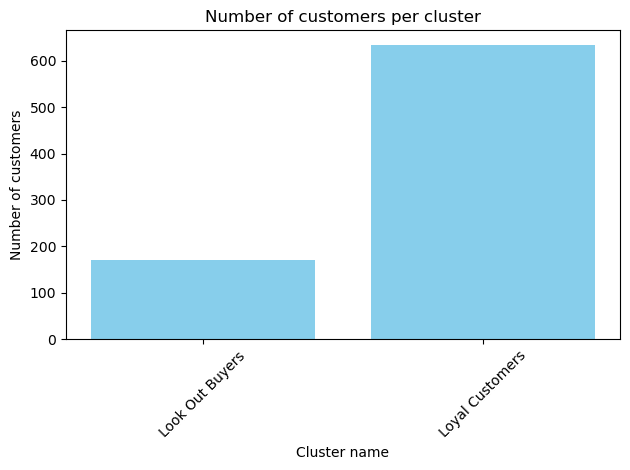

In [18]:
labels = kmeans.labels_

labels_map = {
    0: 'Look Out Buyers',
    1: 'Loyal Customers'
}


label_names = [labels_map[label] for label in labels]

unique, counts = np.unique(label_names, return_counts=True)
cluster_counts = dict(zip(unique, counts))

plt.bar(cluster_counts.keys(), cluster_counts.values(), color='skyblue')
plt.xlabel('Cluster name')
plt.ylabel('Number of customers')
plt.title('Number of customers per cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Clustering Using Davies-Bouldin and Kmeans

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

Best k based on Davies-Bouldin Index: 3


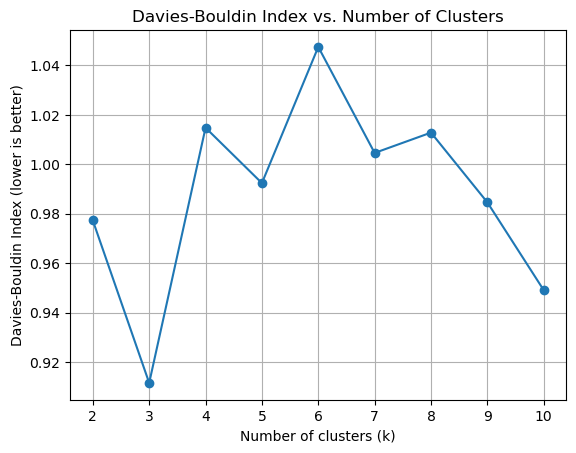

In [19]:
db_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = davies_bouldin_score(X, labels)
    db_scores.append(score)

best_k_db = k_range[db_scores.index(min(db_scores))]
print(f"Best k based on Davies-Bouldin Index: {best_k_db}")

plt.plot(k_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index (lower is better)')
plt.grid(True)
plt.show()

In [20]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [21]:
df3['Cluster'] = kmeans.labels_

cluster_summary = df3.groupby('Cluster')[['R', 'F', 'M']].mean().round(2)
print(cluster_summary)

            R     F     M
Cluster                  
0        0.44  0.17  0.07
1        0.07  0.50  0.18
2        0.07  0.25  0.08


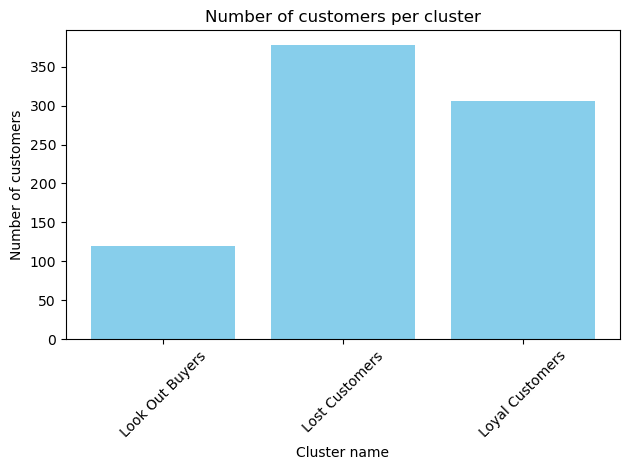

In [22]:
labels = kmeans.labels_

labels_map = {
    0: 'Look Out Buyers',
    1: 'Loyal Customers',
    2: 'Lost Customers'
}

label_names = [labels_map[label] for label in labels]

unique, counts = np.unique(label_names, return_counts=True)
cluster_counts = dict(zip(unique, counts))

plt.bar(cluster_counts.keys(), cluster_counts.values(), color='skyblue')
plt.xlabel('Cluster name')
plt.ylabel('Number of customers')
plt.title('Number of customers per cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()